In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format

from experiments import *

import sys

sys.path.insert(1, '../fuzzylearn/')

from fuzzylearn import *
from fuzzylearn.fuzzifiers import LinearFuzzifier, CrispFuzzifier,ExponentialFuzzifier,QuantileLinearPiecewiseFuzzifier, QuantileConstantPiecewiseFuzzifier
from fuzzylearn.kernel import GaussianKernel, LinearKernel, HyperbolicKernel, PolynomialKernel, HomogeneousPolynomialKernel
from fuzzylearn import solve_optimization_gurobi

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler, PowerTransformer, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

dataset = pd.read_excel("dataset/IncidentiModificato.xlsx")
dataset = dataset.set_index("VERBALE")

In [2]:
import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,10893,0,81,84.00,1.75,27.43,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,10970,1,69,69.00,1.62,26.29,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,11026,1,71,67.00,1.55,27.89,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,11122,1,54,60.00,1.59,23.73,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,11130,1,78,69.00,1.67,24.74,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [3]:
mu1 = dataset['Mezzo'].values
mu0 = [0 if x else 1 for x in mu1]


# Lesioni 20

In [4]:
values = dataset[list(dataset.columns)[7:27]].values
values_scal = StandardScaler().fit_transform(values)
values_20d = PCA(n_components=20).fit_transform(values_scal)

In [5]:
be1l = FuzzyInductor(fuzzifier=ExponentialFuzzifier,c=0.1,k=HyperbolicKernel(1, 0.01))
be0l = FuzzyInductor(fuzzifier=LinearFuzzifier,c=0.1,k=LinearKernel())
besl = [be1l,be0l]

classes = (1,0)

In [6]:
def to_membership_values(labels, target):
    return [1 if l==target else 0 for l in labels]

In [7]:
def get_estimated_membership(bes,classes,data_index,data_values,data_labels):
    n = len(data_values)

    permuted_indices = np.random.permutation(n)
    train_indices = permuted_indices[:int(n*0.7)]
    test_indices = permuted_indices[int(n*0.7):]
    
    train_values = [data_values[i] for i in train_indices]
    
    test_values = [data_values[i] for i in test_indices]
    
    train_values_arr = np.asarray(train_values)
    
    mu = {} 
    mu_train = {}
    mu_test = {}
    
    for target in classes:
            mu[target] = to_membership_values(data_labels, target)
            mu_train[target] = [mu[target][i] for i in train_indices]
            mu_test[target] = [mu[target][i] for i in test_indices]
            
    labels_train = [data_labels[i] for i in train_indices]
    labels_test = [data_labels[i] for i in test_indices]
        
    est_mu = {}
        
    targets = classes
        
    for target,be in zip(targets,bes):
        be.fit(train_values_arr, mu_train[target], n_jobs=-1)
        est_mu[target] = be.estimated_membership_

        if len(est_mu.values()) < len(classes):
            continue # at least one class not inferred
    """    
    #print(est_mu)
    
    index_train = [data_index[i] for i in train_indices]
    index_test = [data_index[i] for i in test_indices]
    
    results_train = list(zip(index_train,\
                             map(lambda x:x,train_values),\
                             map(lambda x : est_mu[0](x),train_values),\
                             map(lambda x: est_mu[1](x),train_values)))
    
    results_test = list(zip(index_test,\
                             map(lambda x:x,test_values),\
                             map(lambda x : est_mu[0](x),test_values),\
                             map(lambda x: est_mu[1](x),test_values)))
    
    return results_train, results_test
    """
    return est_mu

In [8]:
est_mul = get_estimated_membership(besl,classes,dataset.index,values_20d,mu1)

100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


In [9]:
Xl = values_20d
y1l = [est_mul[1](item) for item in Xl]
y0l = [est_mul[0](item) for item in Xl]

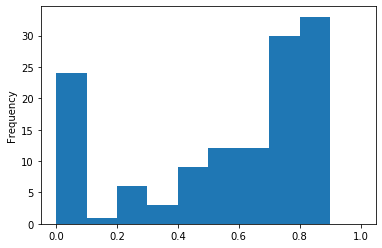

In [23]:
pd.Series(y0l).plot.hist(bins=np.arange(0,1.1,0.1))
plt.savefig('lesioni0-membership-hist.pdf')

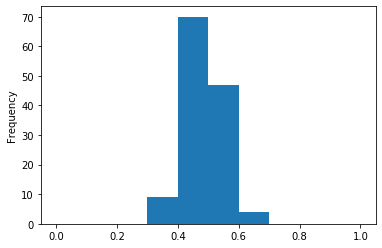

In [24]:
pd.Series(y1l).plot.hist(bins=np.arange(0,1.1,0.1))
plt.savefig('lesioni1-membership-hist.pdf')

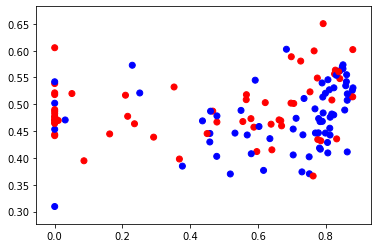

In [36]:
plt.scatter(y0l,y1l,c=['red' if m else 'blue' for m in mezzo])
#plt.savefig('lesioni-membership-scatter.pdf')

In [13]:
pd.crosstab(index=pd.cut(pd.Series(y0l), bins=np.arange(0,1.1,0.1), right=False),
            columns=pd.cut(pd.Series(y1l), bins=np.arange(0,1.1,0.1), right=False))

col_0,"[0.3, 0.4)","[0.4, 0.5)","[0.5, 0.6)","[0.6, 0.7)"
row_0,,,,
"[0.0, 0.1)",2,15,6,1
"[0.1, 0.2)",0,1,0,0
"[0.2, 0.3)",0,3,3,0
"[0.3, 0.4)",2,0,1,0
"[0.4, 0.5)",0,9,0,0
"[0.5, 0.6)",1,8,3,0
"[0.6, 0.7)",1,7,3,1
"[0.7, 0.8)",3,17,9,1
"[0.8, 0.9)",0,10,22,1


In [58]:
aux = pd.DataFrame(index=['[0.0,0.1)','[0.1,0.2)','[0.2,0.3)','[0.3,0.4)','[0.4,0.5)','[0.5,0.6)','[0.6,0.7)',\
                    '[0.7,0.8)','[0.8,0.9)'])
columns = ['[0.3,0.4)','[0.4,0.5)','[0.5,0.6)','[0.6,0.7)']

aux[columns[0]] = [2,0,0,2,0,1,1,3,0]
aux[columns[1]] = [15,1,3,0,9,8,7,17,10]
aux[columns[2]] = [6,0,3,1,0,3,3,9,22]
aux[columns[3]] = [1,0,0,0,0,0,1,1,1]

print(aux.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  [0.3,0.4) &  [0.4,0.5) &  [0.5,0.6) &  [0.6,0.7) \\
\midrule
[0.0,0.1) &          2 &         15 &          6 &          1 \\
[0.1,0.2) &          0 &          1 &          0 &          0 \\
[0.2,0.3) &          0 &          3 &          3 &          0 \\
[0.3,0.4) &          2 &          0 &          1 &          0 \\
[0.4,0.5) &          0 &          9 &          0 &          0 \\
[0.5,0.6) &          1 &          8 &          3 &          0 \\
[0.6,0.7) &          1 &          7 &          3 &          1 \\
[0.7,0.8) &          3 &         17 &          9 &          1 \\
[0.8,0.9) &          0 &         10 &         22 &          1 \\
\bottomrule
\end{tabular}



# DFPCA2Lesioni

In [14]:
anagrafica = dataset[list(dataset.columns)[1:6]]
lesioni = dataset[list(dataset.columns)[7:27]]

labels_zone = ['Testa','Torace','Addome','Scheletro']
labels_zone2 = list(zip(['Testa','Torace','Addome','Scheletro'],list(map(lambda x: x+"2",labels_zone))))

df_compresso2 = anagrafica.copy()
for i,l in zip(range(0,len(lesioni.columns),5),labels_zone2): 
    l1,l2 = l
    zona = lesioni[list(lesioni.columns)[i:(i+5)]]
    component = PCA(n_components=2).fit_transform(zona.values)
    component_to_values1 = [v[0] for v in component]
    serie = pd.Series(component_to_values1,index=zona.index)
    df_compresso2[l1] = serie
    component_to_values2 = [v[1] for v in component]
    serie = pd.Series(component_to_values2,index=zona.index)
    df_compresso2[l2] = serie
df_compresso2.tail()

,SESSO,ANNI,PESO,ALTEZZA,BMI,Testa,Testa2,Torace,Torace2,Addome,Addome2,Scheletro,Scheletro2
VERBALE,,,,,,,,,,,,,
101618,1,82,80.20,1.62,30.56,-1.64,-0.01,-0.92,0.18,-1.29,0.14,-3.13,0.75
101288E,1,70,75.60,1.57,30.67,-1.11,0.37,-1.50,-0.37,-1.29,0.14,-1.02,-1.19
E-97586,0,45,45.00,1.77,14.36,-2.17,-0.39,-0.91,0.19,-1.29,0.14,1.65,1.02
X,0,54,89.60,1.68,31.75,-1.38,-0.88,-0.60,0.57,-0.15,-0.35,0.66,-0.41
X1,1,86,50.00,1.55,20.81,-0.90,-0.95,-0.60,0.57,1.03,-1.68,1.65,0.44


In [15]:
columns_lesioni2 = list(df_compresso2.columns)[5:]

values_pca = df_compresso2[columns_lesioni2].values
values_scal_pca = StandardScaler().fit_transform(values)
values_fpca = values_scal_pca

In [16]:
be1p = FuzzyInductor(fuzzifier=ExponentialFuzzifier,c=0.1,k=HyperbolicKernel(1,0.01))
be0p = FuzzyInductor(fuzzifier=LinearFuzzifier,c=0.1,k=HyperbolicKernel(1,0.01))
besp = [be1p,be0p]

classes = (1,0)

In [17]:
est_mup = get_estimated_membership(besp,classes,df_compresso2.index,values_fpca,mu1)

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


In [18]:
Xp = values_fpca
y1p = [est_mup[1](item) for item in Xp]
y0p = [est_mup[0](item) for item in Xp]

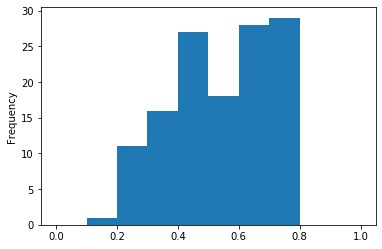

In [26]:
pd.Series(y0p).plot.hist(bins=np.arange(0,1.1,0.1))
plt.savefig('dfpca0-membership-hist.pdf')

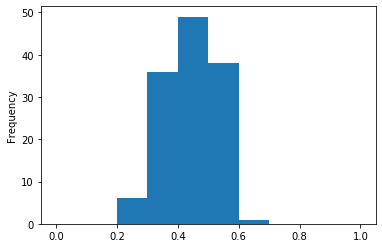

In [27]:
pd.Series(y1p).plot.hist(bins=np.arange(0,1.1,0.1))
plt.savefig('dfpca1-membership-hist.pdf')

In [34]:
mezzo = dataset['Mezzo'].values

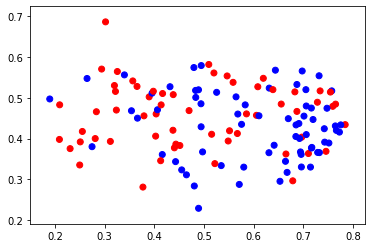

In [37]:
plt.scatter(y0p,y1p,c=['red' if m else 'blue' for m in mezzo])
plt.savefig('dfpca-membership-scatter-alpha.pdf')

In [22]:
pd.crosstab(index=pd.cut(pd.Series(y0p), bins=np.arange(0,1.1,0.1), right=False),
            columns=pd.cut(pd.Series(y1p), bins=np.arange(0,1.1,0.1), right=False))

col_0,"[0.2, 0.3)","[0.3, 0.4)","[0.4, 0.5)","[0.5, 0.6)","[0.6, 0.7)"
row_0,,,,,
"[0.1, 0.2)",0,0,1,0,0
"[0.2, 0.3)",0,5,4,2,0
"[0.3, 0.4)",1,1,4,9,1
"[0.4, 0.5)",2,9,8,8,0
"[0.5, 0.6)",1,4,7,6,0
"[0.6, 0.7)",2,8,10,8,0
"[0.7, 0.8)",0,9,15,5,0
